# Lab #2

Today's lab consists of practice questions to review MLPs and introduce CNNs.

## Question 1
### Classifying newswires: a multi-class classification example
In this example we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Examples include cocoa, soybeans and livestock. Since we have many classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

### The Reuters dataset
We will be working with the Reuters dataset, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look:

In [1]:
# Import needed packages
import tensorflow as tf
import numpy as np
from tensorflow import keras
import pandas as pd
from tensorflow.keras.datasets import reuters
from keras.utils import to_categorical
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load data
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2110848/2110848 [==============================] - 0s 0us/step



Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the data.

We have 8,982 training examples and 2,246 test examples:

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [5]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here's how you can decode it back to words, in case you are curious:

In [9]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[10]])

In [10]:
decoded_newswire

'? period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [11]:
train_labels[10]

3

### Preparing the data
We can vectorize the data with the exact same code as in our previous example:

In [12]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". For a more detailed explanation of one-hot encoding, you can refer to Chapter 6, Section 1 in [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python). In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [13]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

In [14]:
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

### Building our network
This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the dimensionality of the output space is much larger.

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a 16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information. For this reason we will use larger layers.

Build a networks with 2 hidden layers, each with 64 hidden units, and an appropriate output layer. Remember to include the correct `input_shape` in the first hidden layer.

In [15]:
# Define model
model = keras.Sequential([
  layers.Dense(64, activation = 'relu', input_shape=(10000,)),
  layers.Dense(64, activation='relu'),
  layers.Dense(46, activation='softmax')
])

Code the `model.compile` function with `rmsprop` optimizer, `accuracy` performance metric and appropriate loss function.

In [16]:
# Define how to execute training
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Validating our approach
Let's set apart 1,000 samples in our training data to use as a validation set:

In [17]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Train the network for 20 epochs with a batch size of 512. Be sure to make use of the validation set.

In [18]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 70ms/step - loss: 2.7706 - accuracy: 0.4971 - val_loss: 1.8506 - val_accuracy: 0.6340
Epoch 2/20
16/16 [==============================] - 1s 44ms/step - loss: 1.5517 - accuracy: 0.6812 - val_loss: 1.3739 - val_accuracy: 0.6860
Epoch 3/20
16/16 [==============================] - 1s 47ms/step - loss: 1.1783 - accuracy: 0.7399 - val_loss: 1.2085 - val_accuracy: 0.7250
Epoch 4/20
16/16 [==============================] - 1s 49ms/step - loss: 0.9634 - accuracy: 0.7903 - val_loss: 1.0967 - val_accuracy: 0.7500
Epoch 5/20
16/16 [==============================] - 1s 61ms/step - loss: 0.8018 - accuracy: 0.8281 - val_loss: 1.0152 - val_accuracy: 0.7890
Epoch 6/20
16/16 [==============================] - 1s 53ms/step - loss: 0.6690 - accuracy: 0.8602 - val_loss: 0.9666 - val_accuracy: 0.7920
Epoch 7/20
16/16 [==============================] - 1s 79ms/step - loss: 0.5664 - accuracy: 0.8795 - val_loss: 0.9247 - val_accuracy: 0.8050
Epoch 8/20
16


Display its loss and accuracy curves.

In [19]:
import seaborn as sns
sns.set()

train_acc  = history.history['accuracy']
train_loss = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

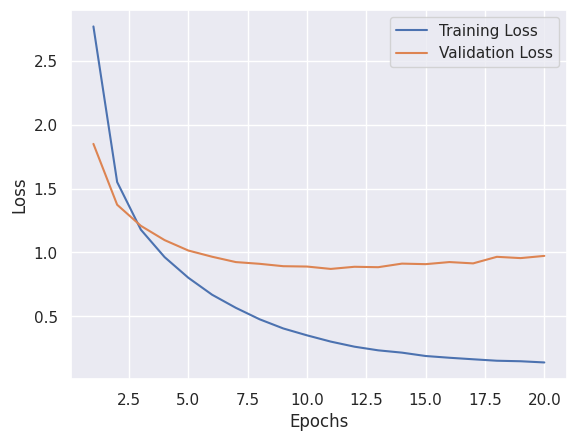

In [20]:
plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

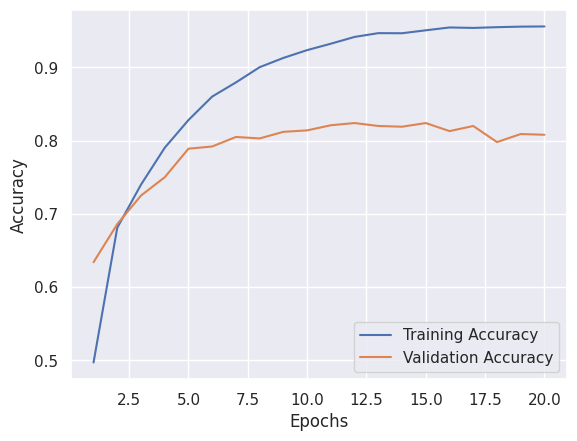

In [21]:
plt.plot(epochs, train_acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

It seems that the network starts overfitting after 8 epochs. Train a new network from scratch for 8 epochs, then evaluate it on the test set.

In [22]:
# Define model
model = keras.Sequential([
  layers.Dense(64, activation = 'relu', input_shape=(10000,)),
  layers.Dense(64, activation='relu'),
  layers.Dense(46, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/8
16/16 [==============================] - 2s 64ms/step - loss: 2.9097 - accuracy: 0.4714 - val_loss: 1.9492 - val_accuracy: 0.6050
Epoch 2/8
16/16 [==============================] - 1s 58ms/step - loss: 1.5955 - accuracy: 0.6728 - val_loss: 1.3997 - val_accuracy: 0.6830
Epoch 3/8
16/16 [==============================] - 1s 64ms/step - loss: 1.1887 - accuracy: 0.7433 - val_loss: 1.2093 - val_accuracy: 0.7390
Epoch 4/8
16/16 [==============================] - 1s 85ms/step - loss: 0.9819 - accuracy: 0.7878 - val_loss: 1.1015 - val_accuracy: 0.7720
Epoch 5/8
16/16 [==============================] - 1s 83ms/step - loss: 0.8207 - accuracy: 0.8231 - val_loss: 1.0242 - val_accuracy: 0.7850
Epoch 6/8
16/16 [==============================] - 1s 59ms/step - loss: 0.6854 - accuracy: 0.8573 - val_loss: 0.9670 - val_accuracy: 0.8060
Epoch 7/8
16/16 [==============================] - 1s 55ms/step - loss: 0.5801 - accuracy: 0.8773 - val_loss: 0.9085 - val_accuracy: 0.8080
Epoch 8/8
71/71 [===

In [23]:
results

[0.9966707229614258, 0.7733749151229858]

Our approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline:

In [24]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.19278717720391808

### On the importance of having sufficiently large intermediate layers
We mentioned earlier that since our final outputs were 46-dimensional, we should avoid intermediate layers with much less than 46 hidden units. See what happens when you introduce an information bottleneck by setting the number of nodes in the second hidden layer to 4.

In [25]:
# Define model
model = keras.Sequential([
  layers.Dense(64, activation = 'relu', input_shape=(10000,)),
  layers.Dense(4, activation='relu'),
  layers.Dense(46, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=512,
          validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 110ms/step - loss: 3.2907 - accuracy: 0.2551 - val_loss: 2.8116 - val_accuracy: 0.3420
Epoch 2/20
16/16 [==============================] - 1s 87ms/step - loss: 2.5288 - accuracy: 0.3951 - val_loss: 2.2190 - val_accuracy: 0.5230
Epoch 3/20
16/16 [==============================] - 1s 60ms/step - loss: 2.0248 - accuracy: 0.5758 - val_loss: 1.8512 - val_accuracy: 0.5800
Epoch 4/20
16/16 [==============================] - 1s 56ms/step - loss: 1.7166 - accuracy: 0.5953 - val_loss: 1.6509 - val_accuracy: 0.5870
Epoch 5/20
16/16 [==============================] - 1s 61ms/step - loss: 1.5363 - accuracy: 0.6114 - val_loss: 1.5480 - val_accuracy: 0.6090
Epoch 6/20
16/16 [==============================] - 1s 53ms/step - loss: 1.4175 - accuracy: 0.6332 - val_loss: 1.4644 - val_accuracy: 0.6300
Epoch 7/20
16/16 [==============================] - 1s 50ms/step - loss: 1.3272 - accuracy: 0.6611 - val_loss: 1.4138 - val_accuracy: 0.6590
Epoch 8/20
1

Our network now seems to peak at ~66% test accuracy, a 12% absolute drop. This drop is mostly due to the fact that we are now trying to compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is too low-dimensional. The network is able to cram most of the necessary information into these 8-dimensional representations, but not all of it.

### Further experiments
1. Try using larger or smaller layers: 32 units, 128 units...
2. We were using two hidden layers. Now try to use a single hidden layer, or three hidden layers.

# Introduction to CNNs
## Question 2: Classifying Digits
Let's revisit the MNIST dataset and build a CNN classifier.

Load the MNIST dataset provided by keras. This contains 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. Split the data into training and testing sets.

In [26]:
# Load data
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Print the shape of the training and test sets.

In [27]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Let's reshape the data to fit the keras format. Don't worry too much about this chunk for now.

In [28]:
from keras import backend as K
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
    x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

Now print the shape again to see what changed.

In [29]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Question 2 in Homework 1 asks you to train a neural network on the Boston housing data. This dataset contains features on very different scales (for example there are both binary features and real-valued features). While the MNIST features take on values between 0 and 1 and do not need to be normalized, we will go through the exercise of normalizing the values before training our network.

Can you think of other algorithms in which normalization is necessary? Is it necessary in the case of neural networks? Why or why not?

- Clustering, PCA, random forest, etc. Not necessary (universal function approximator) but makes training easier in cases in which the features have very different scales.


Normalize the data. Be sure to normalize the test set with the training set mean and standard deviation. Don't forget to convert the training and testing sets to `float32`.

In [30]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

mean = x_train.mean()
x_train -= mean
std = x_train.std()
x_train /= std

x_test -= mean
x_test /= std

How will the code above need to be changed for Boston housing dataset? Why?

- Need to calculate mean and standard deviation per feature, thus need to use something like `x_train.mean(axis=0)`.

Before we define and fit our model let's one-hot encode the labels. Don't forget to do the same for the testing labels and note you will not need to do this step in the case of regression.

In [31]:
y_train.shape

(60000,)

In [32]:

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_train.shape

(60000, 10)

Now fit a shallow convolutional neural network with two `Dense` layers. Include one convolutional layer with 32 convolutional filters of size 3x3 and use the `relu` activation function.

After the convolutional layer, flatten the tensor to be fed into the `Dense` layers.

Add a `Dense` layer with 64 hidden nodes and `relu` activation function.

In the output `Dense` layer use enough output nodes to have one corresponding to each class label (10). What is the activation function you should use here?

In the optimizer use the `Adadelta` optimization function, and choose an appropriate loss function and model performance measure.

Run the network for 5 epochs and use a `batch_size` of 64.

In [33]:
# Define model
model = keras.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape),

  layers.Flatten(),

  layers.Dense(64, activation='relu'),

  layers.Dense(10, activation='softmax')
])

model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adadelta(),
              metrics = ['accuracy'])

model.fit(x_train, y_train, batch_size = 64, epochs = 5, verbose = 1)

Epoch 1/5
938/938 [==============================] - 43s 45ms/step - loss: 1.8549 - accuracy: 0.5273
Epoch 2/5
938/938 [==============================] - 40s 42ms/step - loss: 1.1654 - accuracy: 0.8015
Epoch 3/5
938/938 [==============================] - 40s 42ms/step - loss: 0.8089 - accuracy: 0.8453
Epoch 4/5
938/938 [==============================] - 42s 45ms/step - loss: 0.6287 - accuracy: 0.8652
Epoch 5/5
938/938 [==============================] - 40s 42ms/step - loss: 0.5292 - accuracy: 0.8781


Report the test set accuracy.

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(test_acc)

0.8937000036239624
